#1. ENVIRONMENT SETUP

##Install required packages

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn plotly

##Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

##Set plotting style

In [ ]:
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


#2. DATA LOADING AND PREPROCESSING

In [ ]:
# Load the dataset
df = pd.read_csv('dataset-vehicle_type.csv')

print("📊 Dataset Overview:")
print("=" * 50)
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

# Clean column names
df.columns = df.columns.str.strip()

# Handle missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")
if df.isnull().sum().sum() > 0:
    df = df.fillna(0)

# Create derived features
print("\n Creating derived features...")
df['Total_Vehicles'] = df['Two Wheelers'] + df['Three Wheelers'] + df['Cars'] + df['Buses'] + df['Trucks']
df['Commercial_Sum'] = df['Three Wheelers'] + df['Buses'] + df['Trucks']
df['Personal_Sum'] = df['Two Wheelers'] + df['Cars']

# Calculate percentages (avoid division by zero)
df['Two_Wheeler_Pct'] = np.where(df['Total_Vehicles'] > 0,
                                (df['Two Wheelers'] / df['Total_Vehicles'] * 100), 0)
df['Car_Pct'] = np.where(df['Total_Vehicles'] > 0,
                        (df['Cars'] / df['Total_Vehicles'] * 100), 0)
df['Commercial_Pct'] = np.where(df['Total_Vehicles'] > 0,
                               (df['Commercial_Sum'] / df['Total_Vehicles'] * 100), 0)

print("Data preprocessing completed!")
print(f"New dataset shape: {df.shape}")

📊 Dataset Overview:
Dataset Shape: (592, 7)
Columns: ['State', 'Year', 'Two Wheelers', 'Three Wheelers', 'Cars', 'Buses', 'Trucks']

First 5 rows:
            State  Year  Two Wheelers  Three Wheelers    Cars  Buses  Trucks
0  Andhra Pradesh  2010        171958           20795  151932   4272    6734
1  Andhra Pradesh  2011        187337           21850  107498   3944    9322
2  Andhra Pradesh  2012        379365            5769  214027   2933    6311
3  Andhra Pradesh  2013        153355           44188  234176   3885    7396
4  Andhra Pradesh  2014        308795           32480  176730   3058    8849

Missing values: 0

 Creating derived features...
Data preprocessing completed!
New dataset shape: (592, 13)


#3. EXPLORATORY DATA ANALYSIS (EDA)


📈 EXPLORATORY DATA ANALYSIS
Summary Statistics:
              Year   Two Wheelers  Three Wheelers           Cars        Buses  \
count   592.000000     592.000000      592.000000     592.000000   592.000000   
mean   2017.500000  272995.736486    27146.587838  155705.572635  2733.687500   
std       4.613671  128888.267478    12820.365267   79801.763410  1286.605883   
min    2010.000000   51605.000000     5117.000000   20404.000000   501.000000   
25%    2013.750000  169677.000000    16001.000000   87953.250000  1674.250000   
50%    2017.500000  275466.000000    27427.500000  153119.000000  2634.500000   
75%    2021.250000  384882.000000    38373.750000  222353.000000  3841.250000   
max    2025.000000  497972.000000    49912.000000  299922.000000  4994.000000   

            Trucks  Total_Vehicles  Commercial_Vehicles  Personal_Vehicles  \
count   592.000000      592.000000           592.000000         592.000000   
mean   5601.604730   464183.189189         35481.880068      4287

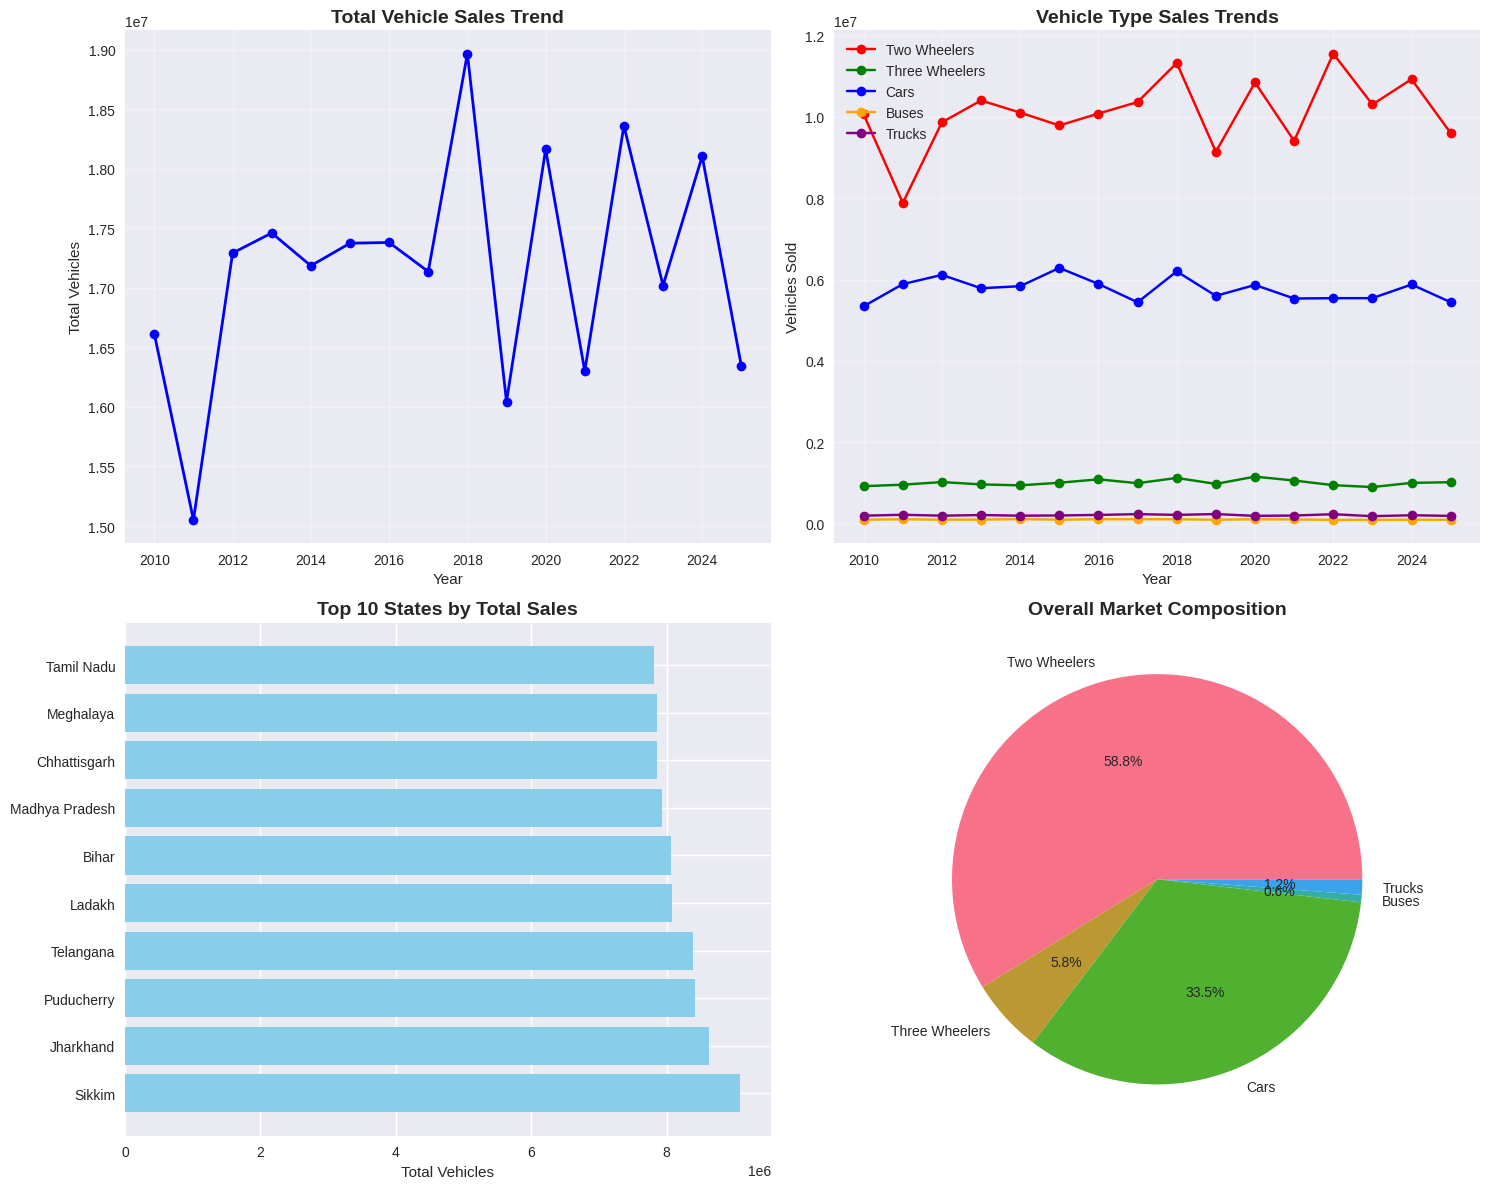

In [4]:
print("\n📈 EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# 3.1 Basic Statistics
print("Summary Statistics:")
print(df.describe())

# 3.2 Time Series Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Total sales trend
yearly_sales = df.groupby('Year')['Total_Vehicles'].sum()
axes[0,0].plot(yearly_sales.index, yearly_sales.values, marker='o', linewidth=2, color='blue')
axes[0,0].set_title('Total Vehicle Sales Trend', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Total Vehicles')
axes[0,0].grid(True, alpha=0.3)

# Vehicle type trends
vehicle_columns = ['Two Wheelers', 'Three Wheelers', 'Cars', 'Buses', 'Trucks']
yearly_by_type = df.groupby('Year')[vehicle_columns].sum()

colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, vehicle in enumerate(vehicle_columns):
    axes[0,1].plot(yearly_by_type.index, yearly_by_type[vehicle],
                   marker='o', label=vehicle, color=colors[i])
axes[0,1].set_title('Vehicle Type Sales Trends', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Vehicles Sold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Top states by total sales
state_sales = df.groupby('State')['Total_Vehicles'].sum().sort_values(ascending=False).head(10)
axes[1,0].barh(range(len(state_sales)), state_sales.values, color='skyblue')
axes[1,0].set_yticks(range(len(state_sales)))
axes[1,0].set_yticklabels(state_sales.index)
axes[1,0].set_title('Top 10 States by Total Sales', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Total Vehicles')

# Market composition pie chart
market_total = df[vehicle_columns].sum()
axes[1,1].pie(market_total.values, labels=market_total.index, autopct='%1.1f%%')
axes[1,1].set_title('Overall Market Composition', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

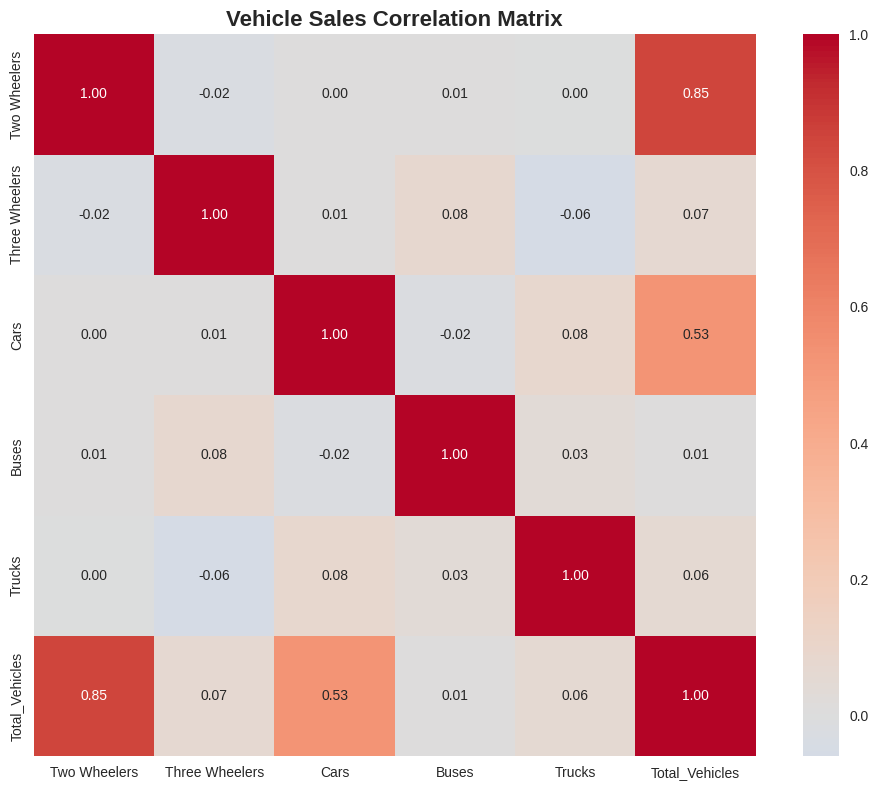

In [3]:
# 3.3 Correlation Analysis
plt.figure(figsize=(10, 8))
numeric_cols = ['Two Wheelers', 'Three Wheelers', 'Cars', 'Buses', 'Trucks', 'Total_Vehicles']
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Vehicle Sales Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. DATA PREPARATION FOR SEGMENTATION

In [ ]:
# Aggregate by state for segmentation
segmentation_features = df.groupby('State').agg({
    'Two Wheelers': 'mean',
    'Three Wheelers': 'mean',
    'Cars': 'mean',
    'Buses': 'mean',
    'Trucks': 'mean',
    'Total_Vehicles': 'mean',
    'Two_Wheeler_Pct': 'mean',
    'Car_Pct': 'mean',
    'Commercial_Pct': 'mean'
}).reset_index()

print(f"Segmentation dataset shape: {segmentation_features.shape}")
print("Features for clustering:")
feature_cols = ['Two Wheelers', 'Three Wheelers', 'Cars', 'Buses', 'Trucks',
                'Two_Wheeler_Pct', 'Car_Pct', 'Commercial_Pct']
print(feature_cols)

# Prepare feature matrix
X = segmentation_features[feature_cols].values
state_names = segmentation_features['State'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data prepared for clustering")

Segmentation dataset shape: (37, 10)
Features for clustering:
['Two Wheelers', 'Three Wheelers', 'Cars', 'Buses', 'Trucks', 'Two_Wheeler_Pct', 'Car_Pct', 'Commercial_Pct']
Data prepared for clustering


#5. FINDING OPTIMAL CLUSTERS


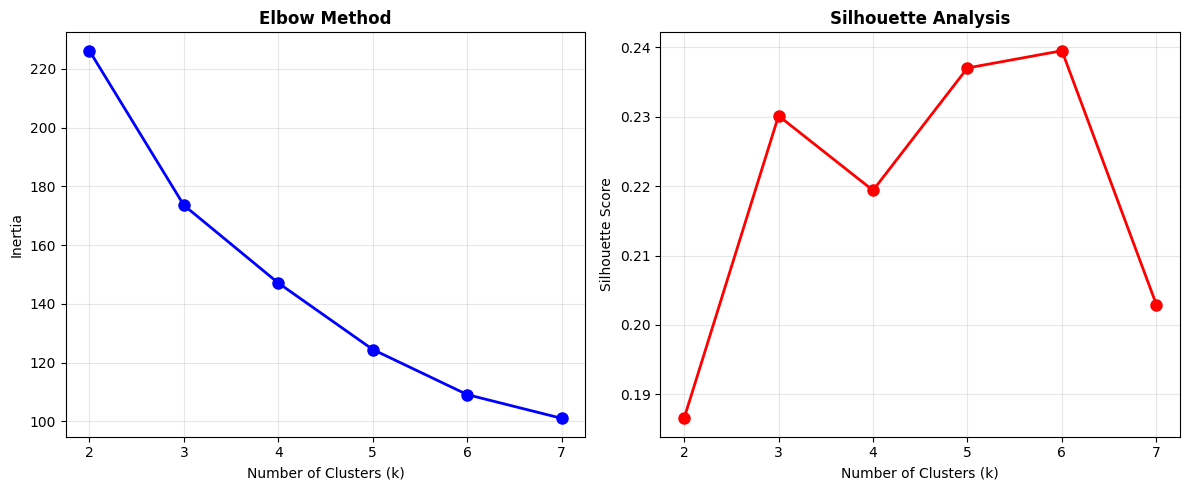

Optimal number of clusters: 6


In [ ]:
# Elbow method and silhouette analysis
k_range = range(2, 8)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

#6. CLUSTERING MODELS

In [ ]:
# Initialize clustering models
clustering_models = {
    'K-Means': KMeans(n_clusters=optimal_k, random_state=42, n_init=10),
    'Hierarchical': AgglomerativeClustering(n_clusters=optimal_k),
    'Gaussian Mixture': GaussianMixture(n_components=optimal_k, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=2)
}

# Apply clustering and evaluate
results = {}
evaluation_metrics = []

for name, model in clustering_models.items():
    print(f"Applying {name}...")

    if name == 'Gaussian Mixture':
        cluster_labels = model.fit_predict(X_scaled)
    else:
        cluster_labels = model.fit_predict(X_scaled)

    results[name] = cluster_labels

    # Calculate metrics if more than one cluster
    if len(np.unique(cluster_labels)) > 1:
        sil_score = silhouette_score(X_scaled, cluster_labels)
        cal_score = calinski_harabasz_score(X_scaled, cluster_labels)
        db_score = davies_bouldin_score(X_scaled, cluster_labels)

        evaluation_metrics.append({
            'Model': name,
            'Silhouette Score': sil_score,
            'Calinski-Harabasz Score': cal_score,
            'Davies-Bouldin Score': db_score,
            'Number of Clusters': len(np.unique(cluster_labels))
        })

# Display evaluation results
evaluation_df = pd.DataFrame(evaluation_metrics)
print("\nModel Evaluation Results:")
print(evaluation_df)

# Select best model
best_model_name = evaluation_df.loc[evaluation_df['Silhouette Score'].idxmax(), 'Model']
best_labels = results[best_model_name]

print(f"\n Best Model: {best_model_name}")
print(f"Silhouette Score: {evaluation_df.loc[evaluation_df['Model'] == best_model_name, 'Silhouette Score'].iloc[0]:.3f}")

Applying K-Means...
Applying Hierarchical...
Applying Gaussian Mixture...
Applying DBSCAN...

Model Evaluation Results:
              Model  Silhouette Score  Calinski-Harabasz Score  \
0           K-Means          0.239525                10.616330   
1      Hierarchical          0.236688                 9.977553   
2  Gaussian Mixture          0.189429                 9.463324   

   Davies-Bouldin Score  Number of Clusters  
0              1.141894                   6  
1              1.103851                   6  
2              1.212051                   6  

 Best Model: K-Means
Silhouette Score: 0.240


#7.VISUALIZATION OF RESULTS

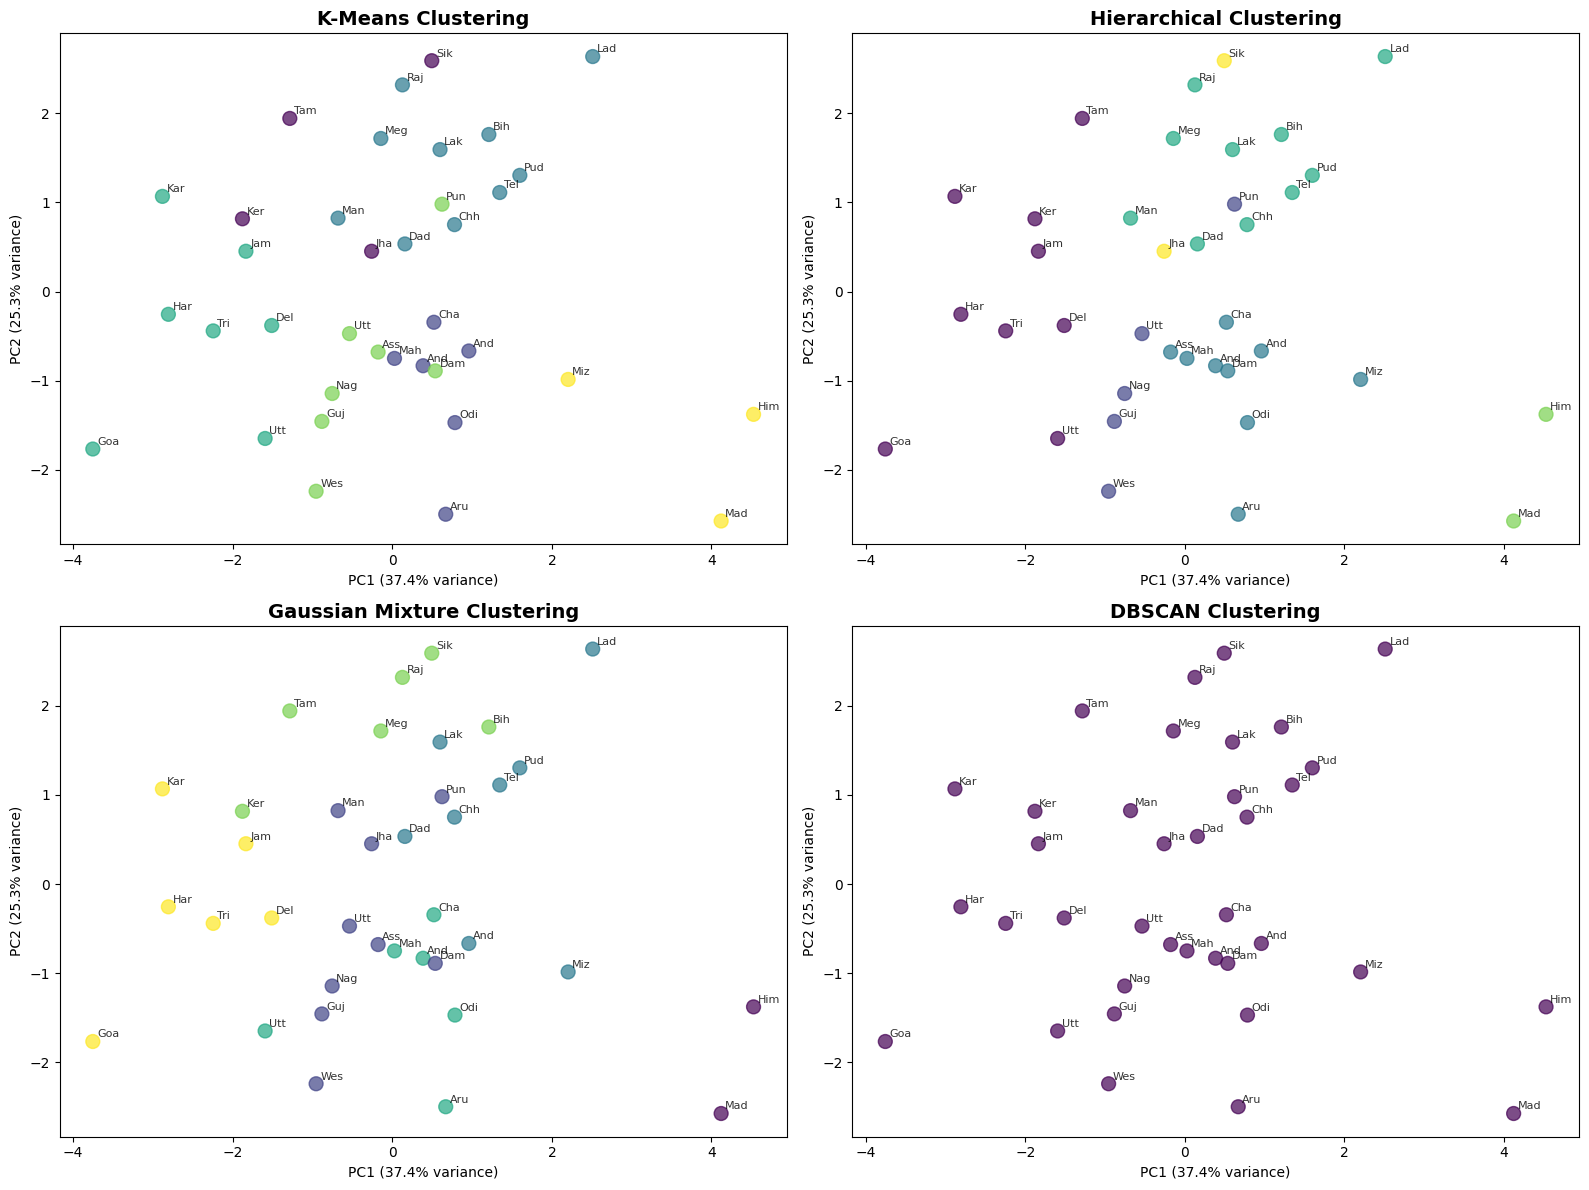

In [ ]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clustering results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

model_names = list(results.keys())
for i, (name, labels) in enumerate(results.items()):
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7, s=100)
    axes[i].set_title(f'{name} Clustering', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')

    # Add state labels
    for j, state in enumerate(state_names):
        axes[i].annotate(state[:3], (X_pca[j, 0], X_pca[j, 1]),
                        xytext=(3, 3), textcoords='offset points',
                        fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

#8. DETAILED CLUSTER ANALYSIS

Cluster Characteristics (Mean Values):
         Two Wheelers  Three Wheelers       Cars    Buses   Trucks  \
Cluster                                                              
0           290436.92        28635.33  182232.45  3213.58  5426.44   
1           274046.02        26394.25  140807.21  2996.64  6105.74   
2           291376.22        25222.74  171274.04  2468.79  5451.88   
3           226509.98        27057.88  151242.12  2858.59  6112.41   
4           262428.30        30293.25  147125.96  2586.20  4958.03   
5           319496.08        25943.90  128672.06  2503.65  5635.79   

         Two_Wheeler_Pct  Car_Pct  Commercial_Pct  
Cluster                                            
0                  54.79    36.98            8.23  
1                  59.41    31.99            8.60  
2                  57.33    35.18            7.50  
3                  52.64    37.31           10.05  
4                  56.73    33.51            9.75  
5                  65.48    26.84   

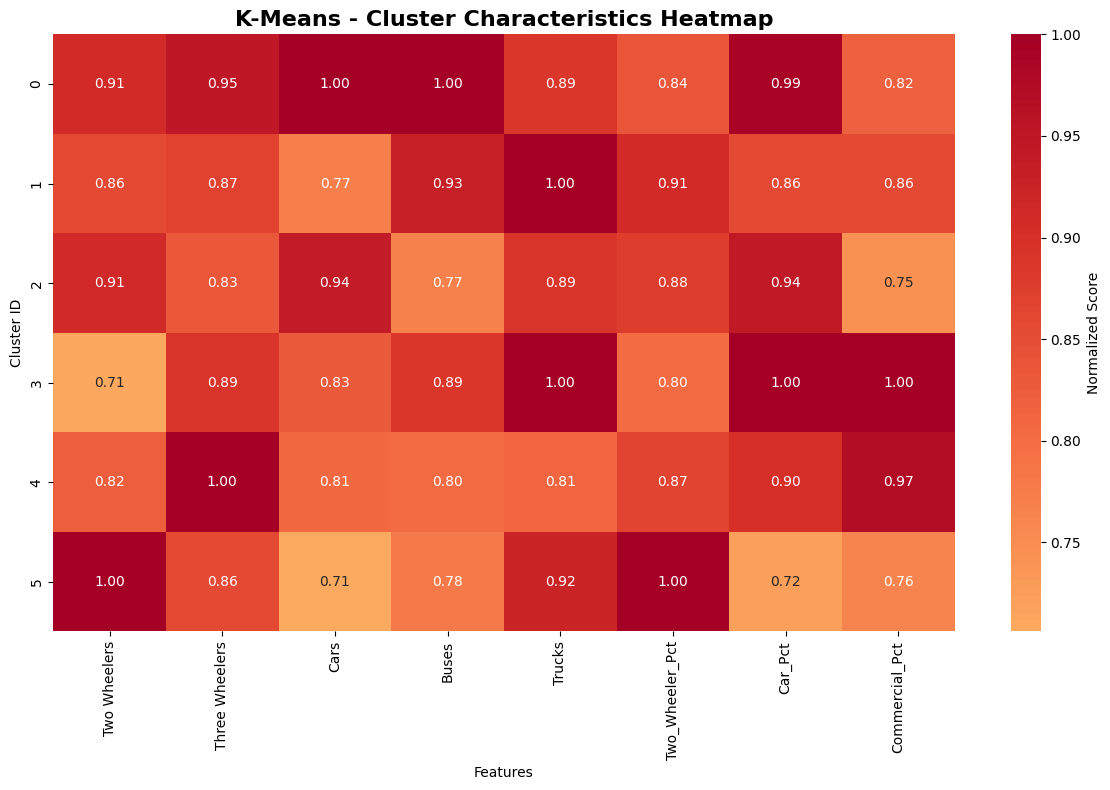


🗺️ CLUSTER COMPOSITION:

Cluster 0 (4 states):
States: Jharkhand, Kerala, Sikkim, Tamil Nadu
Average Total Vehicles: 509,945

Cluster 1 (6 states):
States: Andaman & Nicobar, Andhra Pradesh, Arunachal Pradesh, Chandigarh, Maharashtra, Odisha
Average Total Vehicles: 450,350

Cluster 2 (10 states):
States: Bihar, Chhattisgarh, Dadra & Nagar Haveli, Ladakh, Lakshadweep, Manipur, Meghalaya, Puducherry, Rajasthan, Telangana
Average Total Vehicles: 495,794

Cluster 3 (7 states):
States: Delhi, Goa, Haryana, Jammu & Kashmir, Karnataka, Tripura, Uttarakhand
Average Total Vehicles: 413,781

Cluster 4 (7 states):
States: Assam, Daman & Diu, Gujarat, Nagaland, Punjab, Uttar Pradesh, West Bengal
Average Total Vehicles: 447,392

Cluster 5 (3 states):
States: Himachal Pradesh, Madhya Pradesh, Mizoram
Average Total Vehicles: 482,251


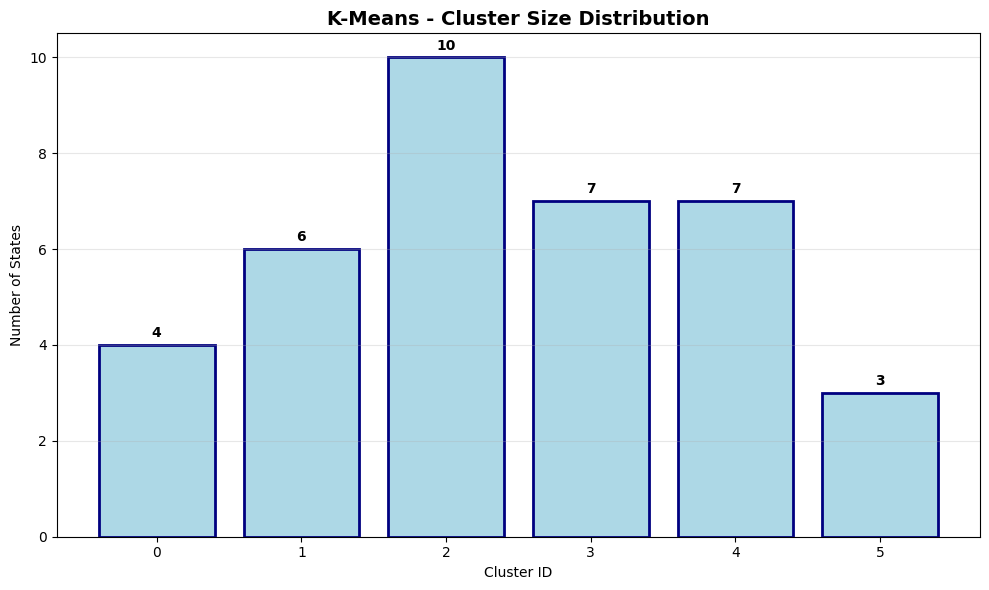

In [ ]:
# Add cluster labels to segmentation data
segmentation_features['Cluster'] = best_labels

# Cluster characteristics
cluster_summary = segmentation_features.groupby('Cluster')[feature_cols].mean()
print("Cluster Characteristics (Mean Values):")
print(cluster_summary.round(2))

# Visualize cluster characteristics
plt.figure(figsize=(12, 8))
cluster_normalized = cluster_summary.div(cluster_summary.max(axis=0), axis=1)
sns.heatmap(cluster_normalized, annot=True, cmap='RdYlBu_r', center=0.5,
            fmt='.2f', cbar_kws={'label': 'Normalized Score'})
plt.title(f'{best_model_name} - Cluster Characteristics Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

# Cluster composition
print("\n🗺️ CLUSTER COMPOSITION:")
for cluster_id in sorted(np.unique(best_labels)):
    cluster_states = segmentation_features[segmentation_features['Cluster'] == cluster_id]['State'].tolist()
    cluster_size = len(cluster_states)
    avg_total = segmentation_features[segmentation_features['Cluster'] == cluster_id]['Total_Vehicles'].mean()

    print(f"\nCluster {cluster_id} ({cluster_size} states):")
    print(f"States: {', '.join(cluster_states)}")
    print(f"Average Total Vehicles: {avg_total:,.0f}")

# Cluster size visualization
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color='lightblue', edgecolor='navy', linewidth=2)
plt.title(f'{best_model_name} - Cluster Size Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Number of States')
plt.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

#9. INSIGHTS AND RECOMMENDATION

In [ ]:
# Create detailed profiles for each cluster
for cluster_id in sorted(np.unique(best_labels)):
    cluster_data = segmentation_features[segmentation_features['Cluster'] == cluster_id]

    print(f"\n{'='*20} SEGMENT {cluster_id} {'='*20}")
    print(f"Number of States: {len(cluster_data)}")
    print(f"States: {', '.join(cluster_data['State'].tolist())}")
    print(f"\nKey Characteristics:")
    print(f"  • Average Total Vehicles: {cluster_data['Total_Vehicles'].mean():,.0f}")
    print(f"  • Two-Wheeler Market Share: {cluster_data['Two_Wheeler_Pct'].mean():.1f}%")
    print(f"  • Car Market Share: {cluster_data['Car_Pct'].mean():.1f}%")
    print(f"  • Commercial Vehicle Share: {cluster_data['Commercial_Pct'].mean():.1f}%")

    # Segment classification based on characteristics
    two_wheeler_pct = cluster_data['Two_Wheeler_Pct'].mean()
    car_pct = cluster_data['Car_Pct'].mean()
    commercial_pct = cluster_data['Commercial_Pct'].mean()

    if two_wheeler_pct > 70:
        segment_type = "Two-Wheeler Dominant Market"
    elif car_pct > 25:
        segment_type = "Balanced/Car-Growing Market"
    elif commercial_pct > 15:
        segment_type = "Commercial Vehicle Focused Market"
    else:
        segment_type = "Mixed Vehicle Market"

    print(f"  • Segment Type: {segment_type}")

print("\n🎯 STRATEGIC RECOMMENDATIONS:")
print("=" * 40)

recommendations = {
    "Two-Wheeler Dominant": "Focus on electric scooters and motorcycles with competitive pricing",
    "Balanced/Car-Growing": "Diversified EV portfolio with emphasis on electric cars",
    "Commercial Vehicle Focused": "Target electric buses, trucks, and commercial three-wheelers",
    "Mixed Vehicle": "Flexible approach with multiple EV categories"
}

for segment_type, recommendation in recommendations.items():
    print(f"• {segment_type}: {recommendation}")


==================== SEGMENT 0 ====================
Number of States: 4
States: Jharkhand, Kerala, Sikkim, Tamil Nadu

Key Characteristics:
  • Average Total Vehicles: 509,945
  • Two-Wheeler Market Share: 54.8%
  • Car Market Share: 37.0%
  • Commercial Vehicle Share: 8.2%
  • Segment Type: Balanced/Car-Growing Market

==================== SEGMENT 1 ====================
Number of States: 6
States: Andaman & Nicobar, Andhra Pradesh, Arunachal Pradesh, Chandigarh, Maharashtra, Odisha

Key Characteristics:
  • Average Total Vehicles: 450,350
  • Two-Wheeler Market Share: 59.4%
  • Car Market Share: 32.0%
  • Commercial Vehicle Share: 8.6%
  • Segment Type: Balanced/Car-Growing Market

==================== SEGMENT 2 ====================
Number of States: 10
States: Bihar, Chhattisgarh, Dadra & Nagar Haveli, Ladakh, Lakshadweep, Manipur, Meghalaya, Puducherry, Rajasthan, Telangana

Key Characteristics:
  • Average Total Vehicles: 495,794
  • Two-Wheeler Market Share: 57.3%
  • Car Market 

#10. COMPREHENSIVE DASHBOARD#

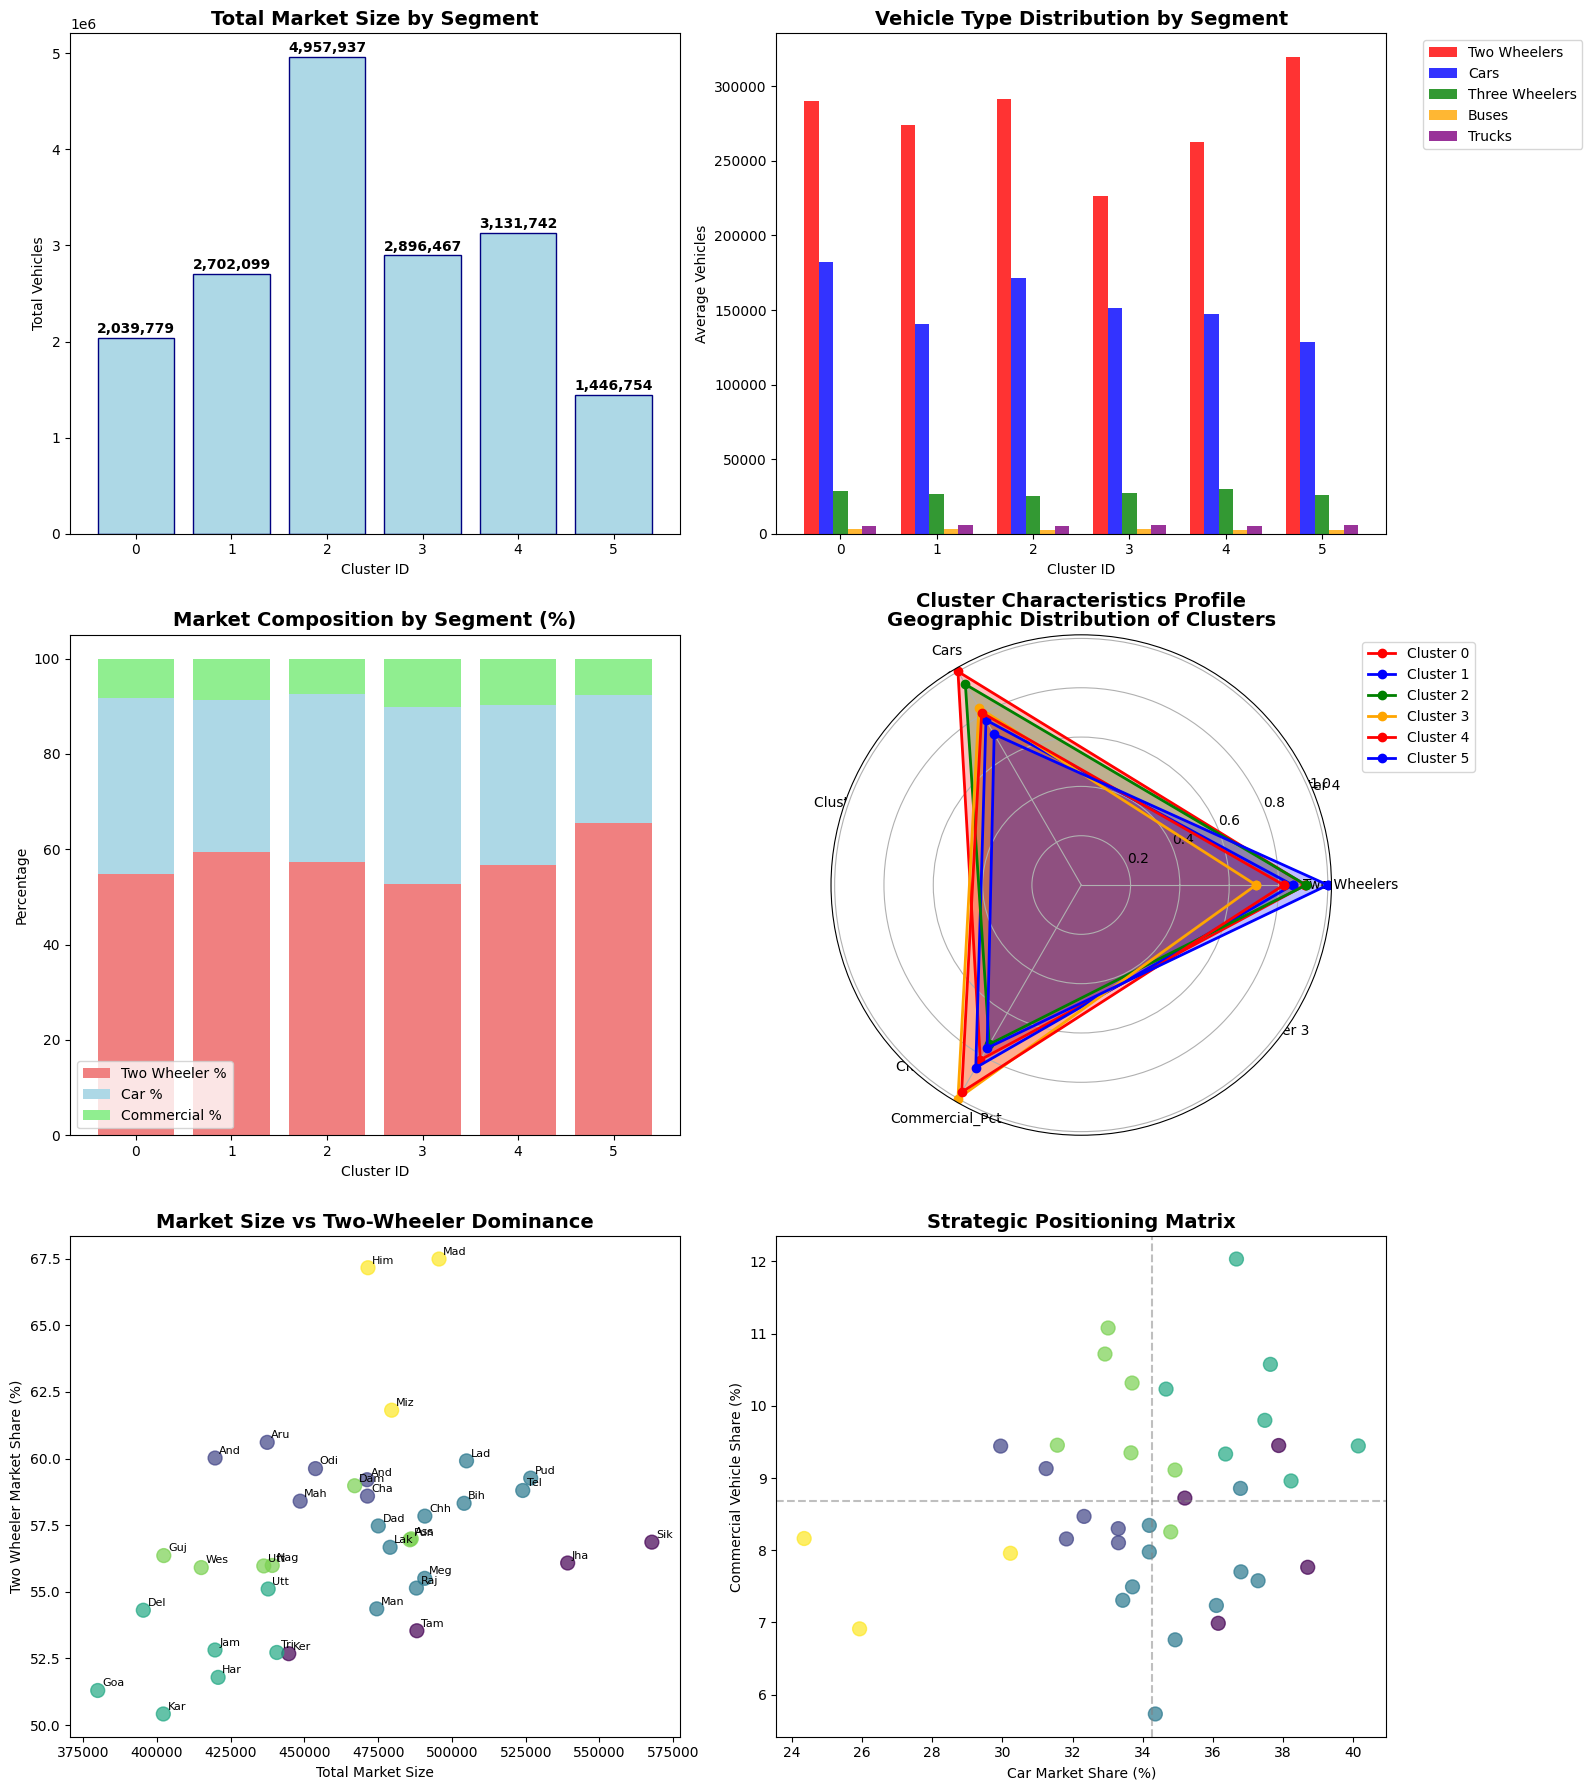

In [ ]:
# Create comprehensive visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Market size by segment
cluster_totals = segmentation_features.groupby('Cluster')['Total_Vehicles'].sum()
axes[0,0].bar(cluster_totals.index, cluster_totals.values, color='lightblue', edgecolor='navy')
axes[0,0].set_title('Total Market Size by Segment', fontweight='bold', fontsize=14)
axes[0,0].set_xlabel('Cluster ID')
axes[0,0].set_ylabel('Total Vehicles')
for i, v in enumerate(cluster_totals.values):
    axes[0,0].text(cluster_totals.index[i], v + max(cluster_totals.values)*0.01,
                   f'{v:,.0f}', ha='center', fontweight='bold')

# 2. Vehicle type distribution by segment
vehicle_types = ['Two Wheelers', 'Cars', 'Three Wheelers', 'Buses', 'Trucks']
cluster_vehicle_dist = segmentation_features.groupby('Cluster')[vehicle_types].mean()

x_pos = np.arange(len(cluster_vehicle_dist.index))
width = 0.15

colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, vehicle_type in enumerate(vehicle_types):
    axes[0,1].bar(x_pos + i*width, cluster_vehicle_dist[vehicle_type],
                  width, label=vehicle_type, color=colors[i], alpha=0.8)

axes[0,1].set_title('Vehicle Type Distribution by Segment', fontweight='bold', fontsize=14)
axes[0,1].set_xlabel('Cluster ID')
axes[0,1].set_ylabel('Average Vehicles')
axes[0,1].set_xticks(x_pos + width * 2)
axes[0,1].set_xticklabels(cluster_vehicle_dist.index)
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Market share percentages by segment
percentage_cols = ['Two_Wheeler_Pct', 'Car_Pct', 'Commercial_Pct']
cluster_percentages = segmentation_features.groupby('Cluster')[percentage_cols].mean()

bottom = np.zeros(len(cluster_percentages.index))
colors_pct = ['lightcoral', 'lightblue', 'lightgreen']
labels_pct = ['Two Wheeler %', 'Car %', 'Commercial %']

for i, col in enumerate(percentage_cols):
    axes[1,0].bar(cluster_percentages.index, cluster_percentages[col],
                  bottom=bottom, color=colors_pct[i], label=labels_pct[i])
    bottom += cluster_percentages[col]

axes[1,0].set_title('Market Composition by Segment (%)', fontweight='bold', fontsize=14)
axes[1,0].set_xlabel('Cluster ID')
axes[1,0].set_ylabel('Percentage')
axes[1,0].legend()

# 4. Cluster characteristics radar chart (simplified)
categories = ['Two Wheelers', 'Cars', 'Commercial_Pct']
cluster_radar_data = segmentation_features.groupby('Cluster')[categories].mean()

# Normalize data for radar chart
cluster_radar_normalized = cluster_radar_data.div(cluster_radar_data.max(axis=0), axis=1)

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

ax_radar = plt.subplot(3, 2, 4, projection='polar')
colors_radar = ['red', 'blue', 'green', 'orange']

for i, cluster_id in enumerate(cluster_radar_normalized.index):
    values = cluster_radar_normalized.loc[cluster_id].tolist()
    values += values[:1]  # Complete the circle

    ax_radar.plot(angles, values, 'o-', linewidth=2,
                  label=f'Cluster {cluster_id}', color=colors_radar[i % len(colors_radar)])
    ax_radar.fill(angles, values, alpha=0.25, color=colors_radar[i % len(colors_radar)])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories)
ax_radar.set_title('Cluster Characteristics Profile', fontweight='bold', fontsize=14, pad=20)
ax_radar.legend(bbox_to_anchor=(1.3, 1.0))

# 5. Geographic distribution
state_cluster_map = segmentation_features.set_index('State')['Cluster'].to_dict()
cluster_counts = segmentation_features['Cluster'].value_counts().sort_index()

axes[1,1].pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index],
              autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Geographic Distribution of Clusters', fontweight='bold', fontsize=14)

# 6. Market potential matrix
axes[2,0].scatter(segmentation_features['Total_Vehicles'],
                  segmentation_features['Two_Wheeler_Pct'],
                  c=segmentation_features['Cluster'],
                  cmap='viridis', s=100, alpha=0.7)
axes[2,0].set_xlabel('Total Market Size')
axes[2,0].set_ylabel('Two Wheeler Market Share (%)')
axes[2,0].set_title('Market Size vs Two-Wheeler Dominance', fontweight='bold', fontsize=14)

# Add state labels
for idx, row in segmentation_features.iterrows():
    axes[2,0].annotate(row['State'][:3],
                       (row['Total_Vehicles'], row['Two_Wheeler_Pct']),
                       xytext=(3, 3), textcoords='offset points', fontsize=8)

# 7. Strategic positioning matrix
axes[2,1].scatter(segmentation_features['Car_Pct'],
                  segmentation_features['Commercial_Pct'],
                  c=segmentation_features['Cluster'],
                  cmap='viridis', s=100, alpha=0.7)
axes[2,1].set_xlabel('Car Market Share (%)')
axes[2,1].set_ylabel('Commercial Vehicle Share (%)')
axes[2,1].set_title('Strategic Positioning Matrix', fontweight='bold', fontsize=14)

# Add quadrant lines
axes[2,1].axhline(y=segmentation_features['Commercial_Pct'].mean(),
                  color='gray', linestyle='--', alpha=0.5)
axes[2,1].axvline(x=segmentation_features['Car_Pct'].mean(),
                  color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
